In [1]:
from ellipsx import calc_psi_delta_one_layer_vec, calc_psi_delta_three_layers_vec

In [2]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

In [3]:
import jax
import numpy as np
import jax.numpy as jnp

In [4]:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

In [5]:
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [6]:
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.autolayout'] = True

In [8]:
%matplotlib inline

In [9]:
import optimistix as optx

In [10]:
from jaxtyping import Array, Complex, Float

# Подготовка данных

In [11]:
n_sub = 3.882 - 0.019j
n_f = 1.462 - 0j
d_f = 4
d_0f = 1
d_fs = 1

In [12]:
phi = jnp.linspace(30, 80, 6)

In [13]:
psi, delta = calc_psi_delta_one_layer_vec(phi, n_f, d_f, n_sub)
psi_3l, delta_3l = calc_psi_delta_three_layers_vec(phi, n_f, d_f, n_sub, d_0f, d_fs)

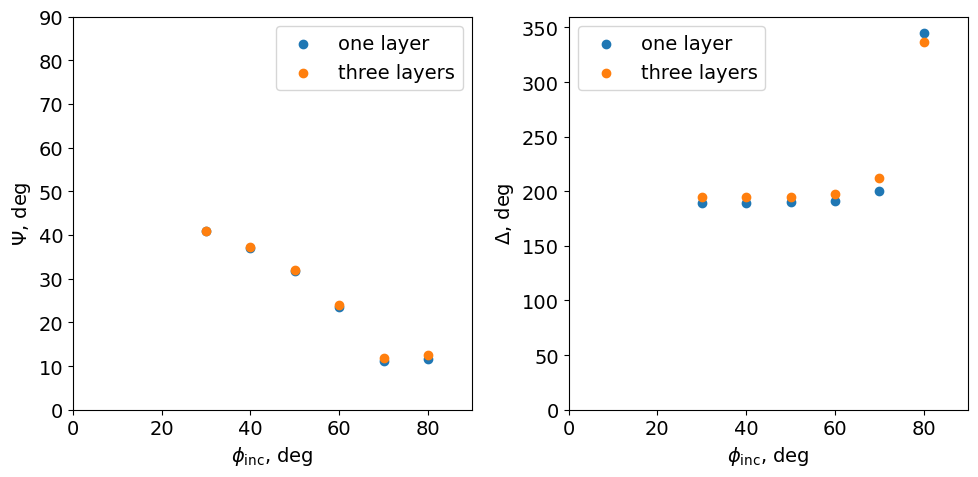

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(phi, psi, label='one layer')
ax1.scatter(phi, psi_3l, label='three layers')
ax2.scatter(phi, delta, label='one layer')
ax2.scatter(phi, delta_3l, label='three layers')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [15]:
from jax import random
key = random.key(20250811)
psi_std = 0.5
delta_std = 1

In [16]:
psi1 = psi + psi_std * random.normal(key, shape=psi.shape)
psi1_std = jnp.ones_like(psi1) * psi_std

In [17]:
delta1 = delta + delta_std * random.normal(key, shape=delta.shape)
delta1_std = jnp.ones_like(delta1) * delta_std

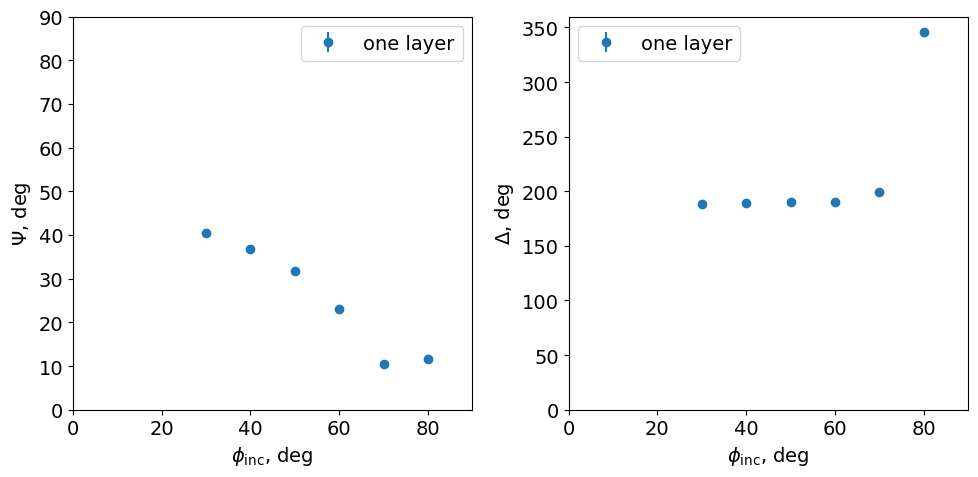

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi1, yerr=psi1_std, label='one layer', fmt='o')
ax2.errorbar(x=phi, y=delta1, yerr=delta1_std, label='one layer', fmt='o')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [19]:
@jax.jit
def residuals(params: Float,
              args: tuple[Float[Array, "5 len"],
                          Float[Array, "2"],
                          Float[Array, "2"],
                          Float[Array, "2"],
                          Float]) -> Float[Array, "len + len"]:
    d_f = params
    
    phi_psi_delta, n_f_, n_sub_, n0_, wl = args
    
    phi = phi_psi_delta[0]
    psi_obs = phi_psi_delta[1]
    psi_std = phi_psi_delta[2]
    delta_obs = phi_psi_delta[3]
    delta_std = phi_psi_delta[4]

    n_f = n_f_[0] + 1j * n_f_[1]
    n_sub = n_sub_[0] + 1j * n_sub_[1]
    n0 = n0_[0] + 1j * n0_[1]

    psi, delta = calc_psi_delta_one_layer_vec(phi, n_f, d_f, n_sub, n0, wl)
    return jnp.concatenate([(psi - psi_obs)/psi_std,
                           (delta - delta_obs)/delta_std])
    

In [20]:
params = jnp.array([5.])

In [21]:
args = (jnp.stack([phi, psi1, psi1_std, delta1, delta1_std]),
        jnp.array([1.46, 0], dtype=float),
        jnp.array([3.9, -0.02], dtype=float),
        jnp.array([1, 0], dtype=float),
        632.8)

In [22]:
args

(Array([[ 30.        ,  40.        ,  50.        ,  60.        ,
          70.        ,  80.        ],
        [ 40.42596806,  36.82010697,  31.78054175,  22.9856682 ,
          10.57032208,  11.70870728],
        [  0.5       ,   0.5       ,   0.5       ,   0.5       ,
           0.5       ,   0.5       ],
        [188.64168884, 188.83288493, 189.97382811, 190.10325535,
         199.63775223, 345.41555075],
        [  1.        ,   1.        ,   1.        ,   1.        ,
           1.        ,   1.        ]], dtype=float64),
 Array([1.46, 0.  ], dtype=float64),
 Array([ 3.9 , -0.02], dtype=float64),
 Array([1., 0.], dtype=float64),
 632.8)

In [23]:
residuals(params, args)

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (2,).

In [82]:
solver = optx.LevenbergMarquardt(rtol=1e-8, atol=1e-8)

In [83]:
sol = optx.least_squares(residuals, solver, params, args, max_steps=1024)

In [86]:
sol.value

Array([ 0.18871674,  0.52965647,  3.8290116 ,  4.234352  , -2.44526611],      dtype=float64)